# Data Analysis

## Load libraries and data

In [1]:
import pandas as pd
from pandas.plotting import lag_plot
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.lines as mlines
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
import yfinance as yf
import numpy as np

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 10)
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15)

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# download the data from 2000 to 2024
data = yf.download('^FCHI', start='2000-01-01', end='2024-01-01')
# reset the index to date
data.reset_index(inplace=True)
data.columns = data.columns.get_level_values('Price')

[*********************100%***********************]  1 of 1 completed


In [3]:
# Converting 'Date' to datetime object
data['Date'] = pd.to_datetime(data['Date'])
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month

## Taking a first look at our data

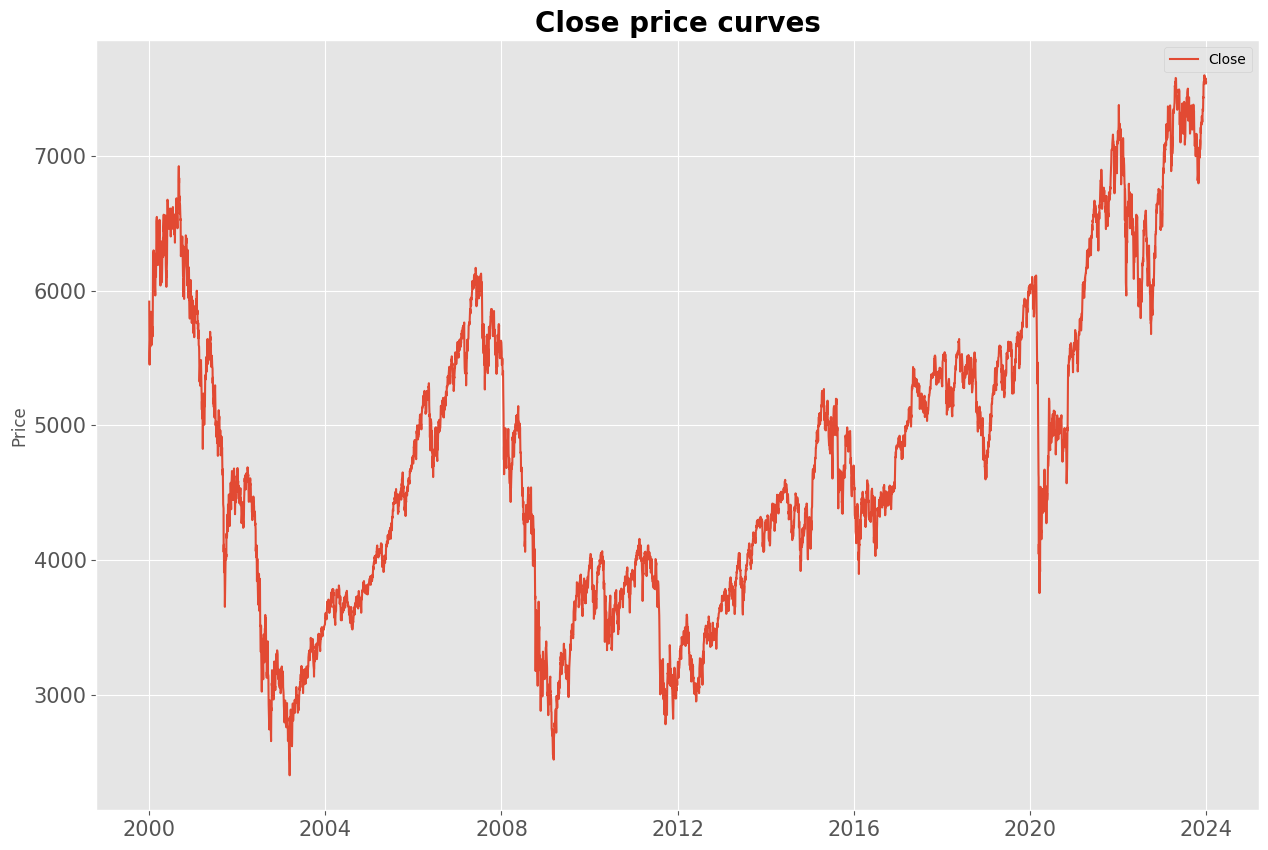

In [4]:
fig, ax = plt.subplots()
ax.plot(data["Date"], data["Close"], label="Close")
ax.set_ylabel("Price")
ax.set_title("Close price curves", fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.legend()
fig.show()

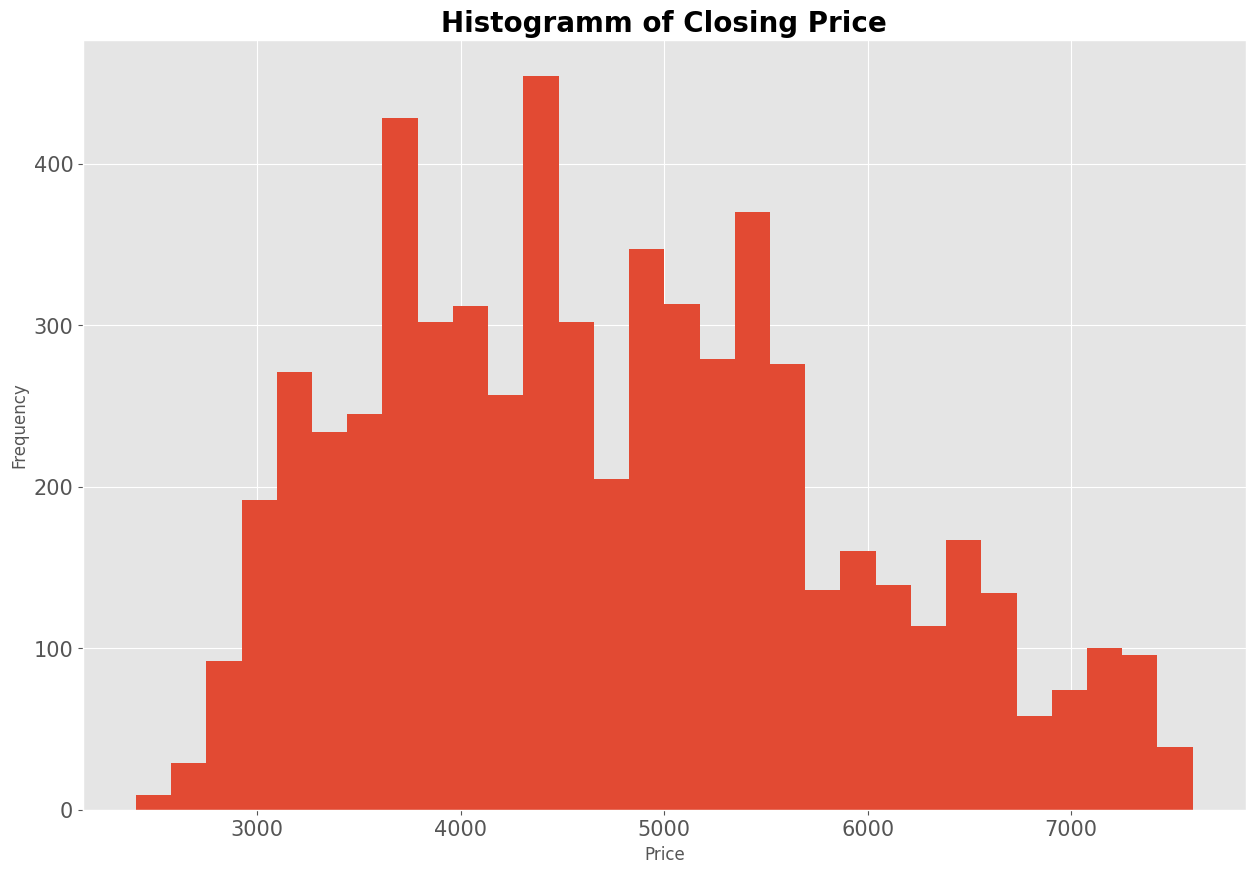

In [5]:
data.Close.plot(kind = "hist", bins = 30)
plt.xlabel("Price")
plt.title("Histogramm of Closing Price", fontsize = 20, fontdict=dict(weight='bold'))
plt.show()

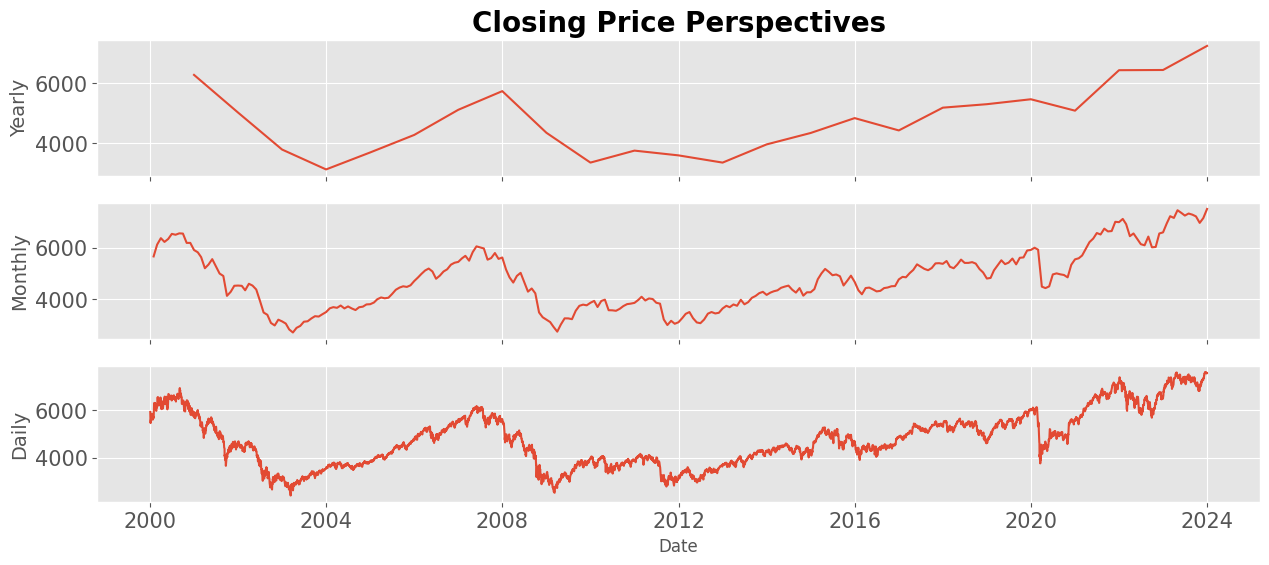

In [6]:
#Create plot
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(15, 6), sharex=True)

# Aggregating the Time Series to a yearly scaled index
y = data[['Date','Close']].copy()
y.set_index('Date', inplace=True)
y.index = pd.to_datetime(y.index)
y = y.resample('1Y').mean()
y['Date'] = y.index

# Plot the yearly Volume Lineplot
sns.lineplot(y['Close'], ax=ax1)

# Aggregating the Time Series to a monthly scaled index
y = data[['Date','Close']].copy()
y.set_index('Date', inplace=True)
y.index = pd.to_datetime(y.index)
y = y.resample('1M').mean()
y['Date'] = y.index

# Plot the Monthly Volume Lineplot
sns.lineplot(y['Close'], ax=ax2)

# Aggregating the Time Series to a daily scaled index
y = data[['Date','Close']].copy()
y.set_index('Date', inplace=True)
y.index = pd.to_datetime(y.index)
y = y.resample('1D').mean()
y['Date'] = y.index

# Plot the daily Volume Lineplot
sns.lineplot( y['Close'], ax=ax3)

ax1.set_title('Closing Price Perspectives', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax1.set_ylabel('Yearly', fontsize = 14)
ax2.set_ylabel('Monthly', fontsize = 14)
ax3.set_ylabel('Daily', fontsize = 14)
# ax1.set_ylabel('Price', fontsize = 16, fontdict=dict(weight='bold'))
# plt.tick_params(axis='y', which='major', labelsize=9)
# plt.tick_params(axis='x', which='major', labelsize=9)
plt.show()

## Autocorrelation

**Autocorrelation** measures the linear relationship between lagged values of a time series, for example between yt and yt−1. If a series is significantly autocorrelated, that means, the previous values of the series (lags) may be helpful in predicting the current value.

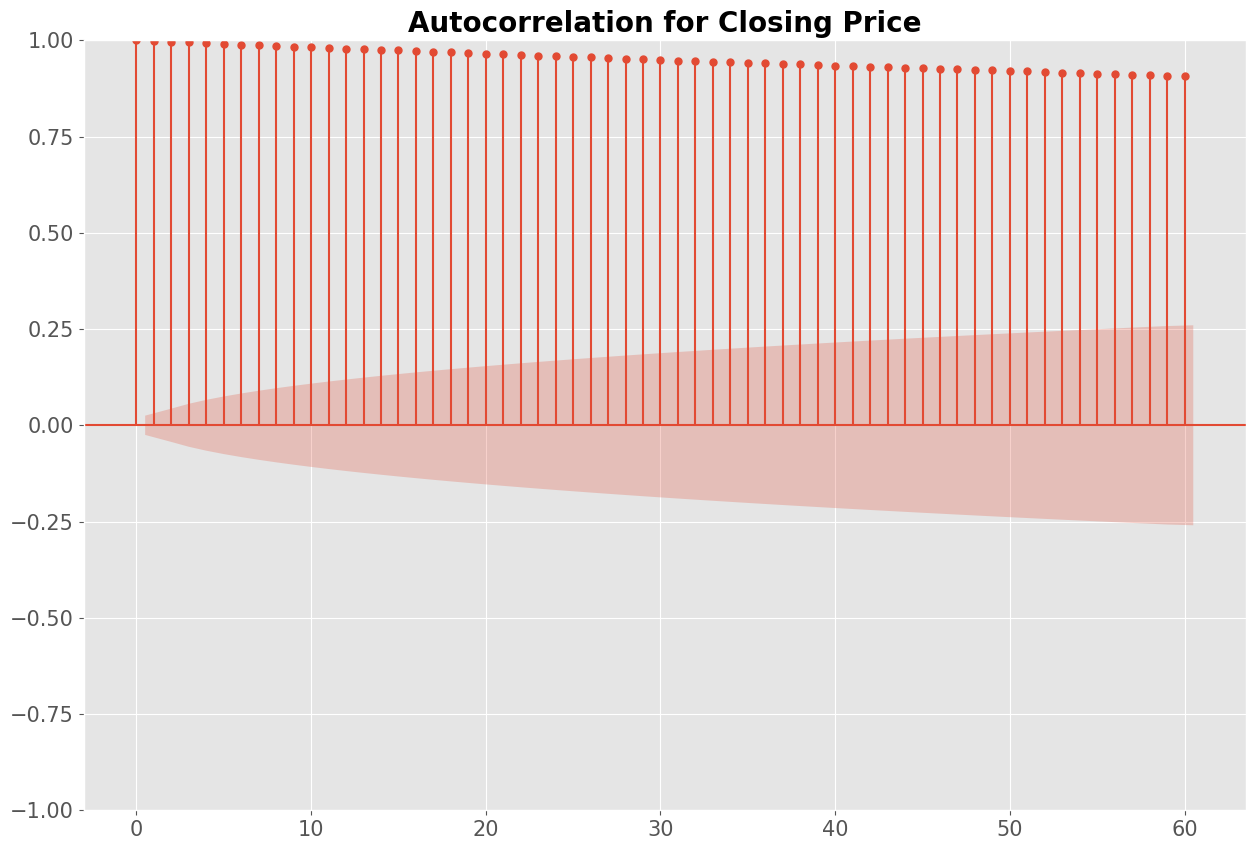

In [7]:
fig = plot_acf(data['Close'].tolist(), lags=60, fft=False);
fig.get_axes()[0].set_title("Autocorrelation for Closing Price", fontsize = 20, fontdict=dict(weight='bold'))
fig.show()

A useful type of plot to explore the relationship between each observation and a lag of that observation is called the scatter plot. It plots the observation at time t on the x-axis and the lag1 observation (t-1) on the y-axis.

* If the points cluster along a diagonal line from the bottom-left to the top-right of the plot, it suggests a positive correlation relationship.

* If the points cluster along a diagonal line from the top-left to the bottom-right, it suggests a negative correlation relationship.

Either relationship is good as they can be modeled.

* More points tighter into the diagonal line suggests a stronger relationship and more spread from the line suggests a weaker relationship.

* A ball in the middle or a spread across the plot suggests a weak or no relationship.

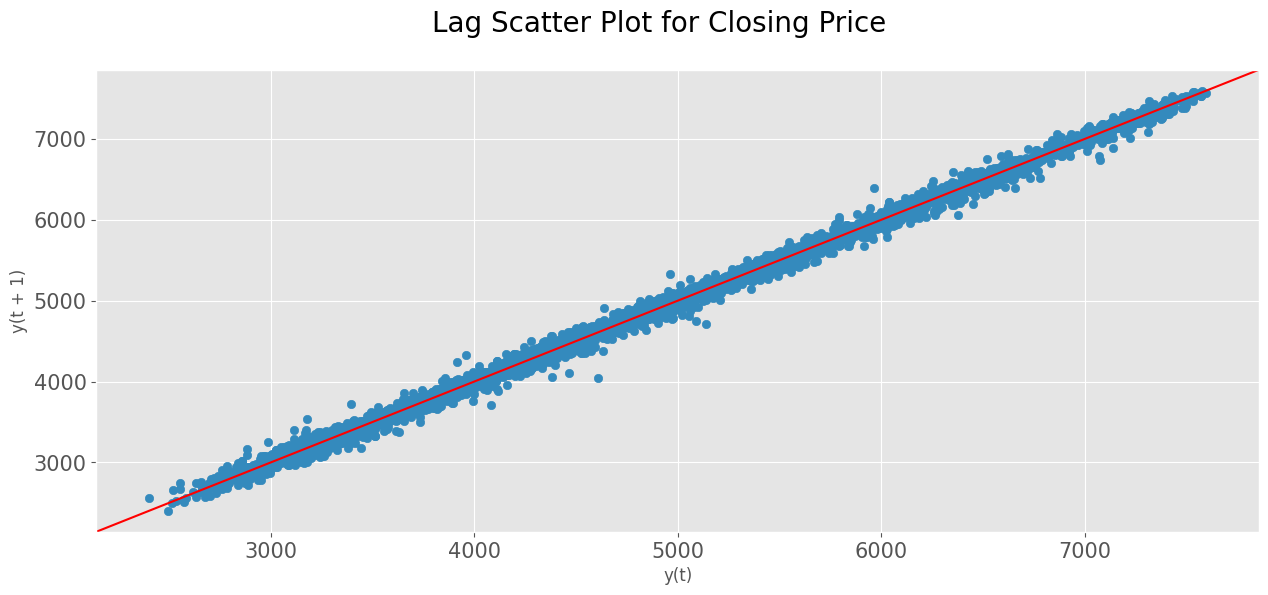

In [8]:
fig, ax = plt.subplots(1,1, figsize=(15, 6))
fig.suptitle("Lag Scatter Plot for Closing Price", fontsize = 20)
lag_plot(data['Close'], ax=ax)

line = mlines.Line2D([0, 1], [0, 1], color='red')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)

# line = mlines.Line2D([1, 0], [0, 1], color='red')
# transform = ax.transAxes
# line.set_transform(transform)
# ax.add_line(line)

fig.show()

## Trend and Seasonality

**Trend** (long term movement): When the series increases (or decreases) over the entire length of time.

**Seasonality** in sime series data, is the presence of variations that occur at specific regular intervals less than a year, such as weekly, monthly, or quarterly.

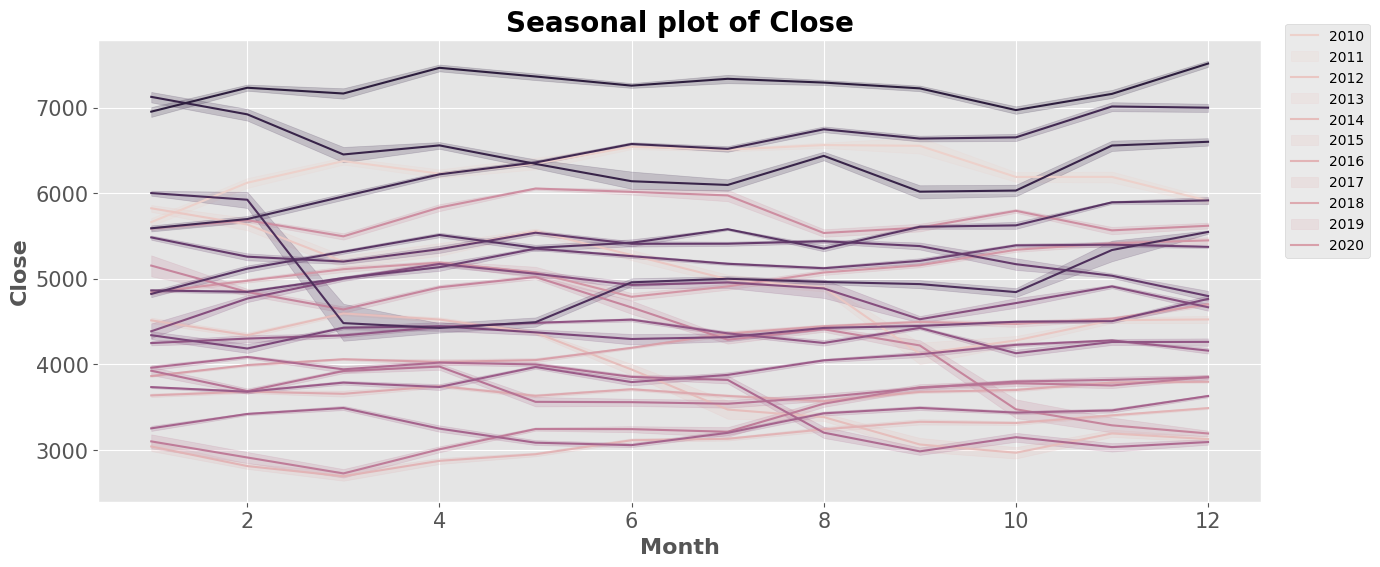

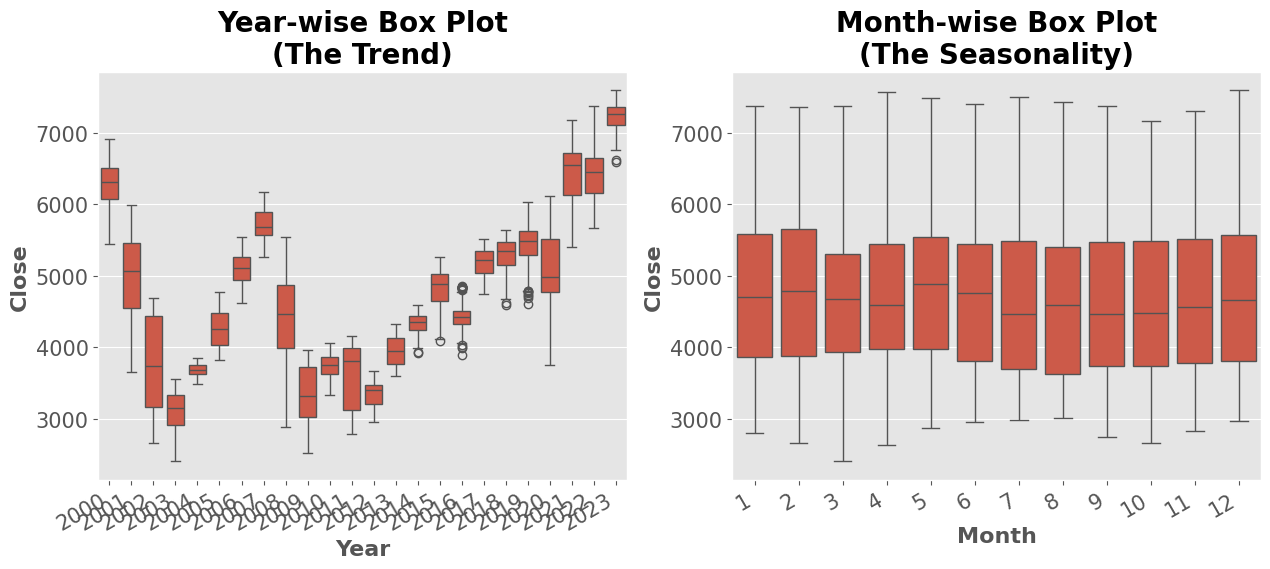

In [9]:
variable = "Close" 
fig, ax = plt.subplots(figsize=(15, 6))

sns.lineplot(x=data['Month'],y=data[variable], hue = data['Year'])
ax.set_title(f'Seasonal plot of {variable}', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Month', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel(f'{variable}', fontsize = 16, fontdict=dict(weight='bold'))
ax.legend(labels = [str(2010+i) for i in range(11)], bbox_to_anchor=(1.1, 1.05))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

sns.boxplot(x=data['Year'], y=data[variable], ax=ax[0])
ax[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax[0].set_xlabel('Year', fontsize = 16, fontdict=dict(weight='bold'))
ax[0].set_ylabel(f'{variable}', fontsize = 16, fontdict=dict(weight='bold'))

sns.boxplot(x=data['Month'], y=data[variable], ax=ax[1])
ax[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax[1].set_xlabel('Month', fontsize = 16, fontdict=dict(weight='bold'))
ax[1].set_ylabel(f'{variable}', fontsize = 16, fontdict=dict(weight='bold'))

fig.autofmt_xdate()

## Timeseries Decomposition

If we assume an additive decomposition, then we can write yt=St+Tt+Rt, where yt is the data, St is the seasonal component, Tt is the trend-cycle component and Rt is the residual component, all at period t. Also, for a multiplicative decomposition, we have yt=St∗Tt∗Rt.

The additive decomposition is the most appropriate if the magnitude of the seasonal fluctuations, or the variation around the trend-cycle, does not vary with the level of the time series. When the variation in the seasonal pattern, or the variation around the trend-cycle, appears to be proportional to the level of the time series, then a multiplicative decomposition is more appropriate. Multiplicative decompositions are common with economic time series, therefore we choose this type of decomposition in our analysis.

The three components are shown separately in the bottom three panels. These components can be multiplied together to reconstruct the data shown in the top panel. 

The residual component shown in the bottom panel is what is left over when the seasonal and trend-cycle components have been removed from the data.

If the seasonal component is removed from the original data, the resulting values are the “seasonally adjusted” data. For an additive decomposition, the seasonally adjusted data are given by yt−St , and for multiplicative data, the seasonally adjusted values are obtained using yt/St.




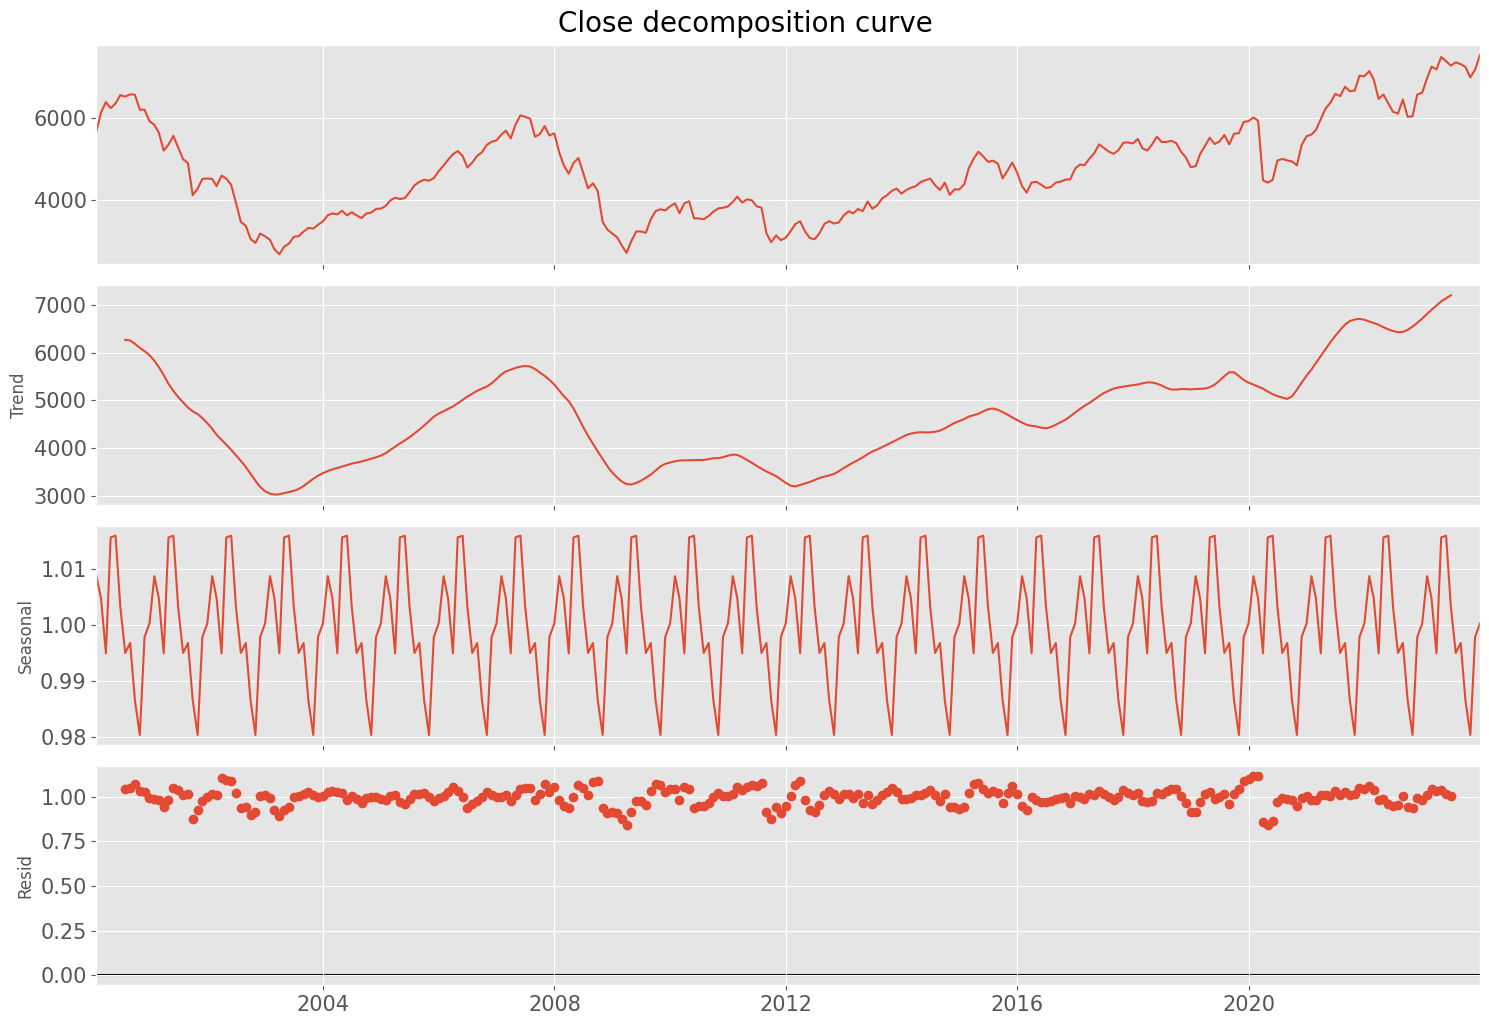

In [10]:
#@title Choose a variable and a time perspective to decompose { run: "auto", vertical-output: true, form-width: "50%", display-mode: "form" }
variable = "Close" #@param ["Close", "Open", "Daily_High", "Daily_Low", "Volume"]
time_perspective = "monthly" #@param ["daily", "monthly"]

# Aggregating the Time Series to a monthly scaled index
y = data[['Date', variable]].copy()
y.set_index('Date', inplace=True)
y.index = pd.to_datetime(y.index)

if time_perspective == 'monthly':
  y = y.resample('1M').mean()

# Using statistical tools of statsmodel library
decomposition = sm.tsa.seasonal_decompose(y, model='multiplicative', period = 12)
fig = decomposition.plot()
fig.suptitle(f'{variable} decomposition curve', fontsize = 20, y=1.02)
fig.show()

The plot represents the **seasonal decomposition of the CAC 40 index** using a multiplicative model, which assumes that the observed data is the product of its trend, seasonal, and residual components. This method is particularly useful for financial data, such as the CAC 40, where variations in trend and seasonality are proportional to the level of the series. The decomposition was performed with a periodicity of 12, which corresponds to monthly data, capturing yearly seasonal cycles.

The observed data, shown in the top panel, represents the raw movements of the CAC 40 index. It reveals a long-term upward trend over the analyzed period, indicative of market growth. However, it also shows significant fluctuations, reflecting the volatility typically associated with stock market indices. These variations are further dissected into their constituent components.

The trend component, displayed in the second panel, isolates the long-term growth trajectory of the CAC 40. This component filters out short-term fluctuations, highlighting the gradual upward movement of the index. By focusing on this trend, one can observe the sustained growth of the market over time, free from the noise of short-term variations.

The seasonal component, shown in the third panel, captures the recurring patterns within the CAC 40. Using a periodicity of 12, this component reflects predictable annual cycles, which may be influenced by factors such as quarterly earnings reports, holiday-driven trading patterns, or broader economic cycles. The seasonal pattern is consistent in its magnitude and timing, demonstrating the cyclicality inherent in financial markets.

The residual component, in the bottom panel, represents the remaining variability in the data after accounting for the trend and seasonal components. This component reveals random or unexplained variations that could stem from unexpected market shocks, external economic factors, or anomalies. While the residuals exhibit some randomness, the presence of potential patterns may indicate areas for further modeling or refinement.

## Stationarity

**What is stationarity:** A stationary time series is one whose properties do not depend on the time at which the series is observed. Thus, time series with trends, or with seasonality, are not stationary. On the other hand, a time series with cyclic behavior (but with no trend or seasonality) is stationary.

**What is stationarity used for:** Most statistical forecasting methods are designed to work on a stationary time series. The first step in the forecasting process is typically to do some transformation to convert a non-stationary series to stationary. Forecasting a stationary series is relatively easier and the forecasts are more reliable.




In [11]:
variable = "Close"
time_perspective = "daily"

# check for stationarity
def adf_test(series, title=''):
    """
    Pass in a time series and an optional title, returns an Adataset report
    """
    print('Augmented Dickey-Fuller Test: {}\n'.format(title))
    # .dropna() handles differenced data
    result = adfuller(series.dropna(),autolag='AIC') 
    
    labels = ['Adataset test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out['critical value ({})'.format(key)]=val
        
    # .to_string() removes the line "dtype: float64"
    print(f'{out.to_string()}\n')          
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")
        
# Aggregating the Time Series to a monthly scaled index
y = data[['Date',variable]].copy()
y.set_index('Date', inplace=True)
y.index = pd.to_datetime(y.index)
if time_perspective == 'monthly':
  y = y.resample('1M').mean()
        
adf_test(y[variable],title=variable) 

# Checl for stationnarity on log-return
print("="*30)
print('Log-Return Augmented Dickey-Fuller Test:\n')
data['Return'] = np.log(data['Close']/data['Close'].shift(1))
y = data[['Date','Return']].copy()
y.set_index('Date', inplace=True)
y.index = pd.to_datetime(y.index)
if time_perspective == 'monthly':
  y = y.resample('1M').mean()

adf_test(y['Return'],title='Log-Return')

Augmented Dickey-Fuller Test: Close

Adataset test statistic      -1.232844
p-value                       0.659310
# lags used                   7.000000
# observations             6126.000000
critical value (1%)          -3.431418
critical value (5%)          -2.862012
critical value (10%)         -2.567021

Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary
Log-Return Augmented Dickey-Fuller Test:

Augmented Dickey-Fuller Test: Log-Return

Adataset test statistic   -1.397679e+01
p-value                    4.247532e-26
# lags used                3.200000e+01
# observations             6.100000e+03
critical value (1%)       -3.431422e+00
critical value (5%)       -2.862014e+00
critical value (10%)      -2.567022e+00

Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


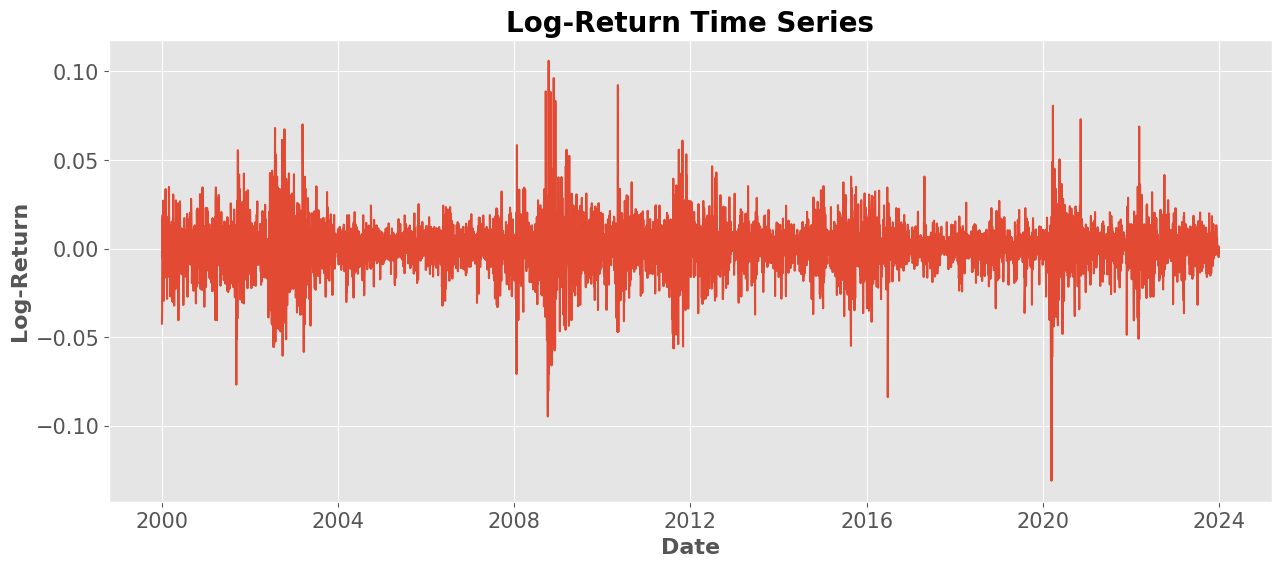

In [12]:
# Plot log-return
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(x=y.index, y=y['Return'], ax=ax)
ax.set_title('Log-Return Time Series', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_ylabel('Log-Return', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_xlabel('Date', fontsize = 16, fontdict=dict(weight='bold'))
fig.show()

It is a common practice to work with the log-return of a financial time series, as it is more likely to be stationary. The log-return is defined as the logarithm of the ratio of the current price to the previous price. It is calculated as log(Pt/Pt−1), where Pt is the price at time t. The log-return is a measure of the relative change in price between two consecutive time points, and it is often used in financial analysis due to its stationarity properties. Following the dicker-fuller test, we can see that the log-return of the CAC 40 index is stationary, which is a desirable property for time series analysis.

## Coefficient of variation

The coefficient of variation (CV) is a statistical measure of the relative dispersion of data points in a data series around the mean. In finance, the coefficient of variation allows investors to determine how much volatility, or risk, is assumed in comparison to the amount of return expected from investments. The lower the ratio of the standard deviation to mean return, the better risk-return trade-off.

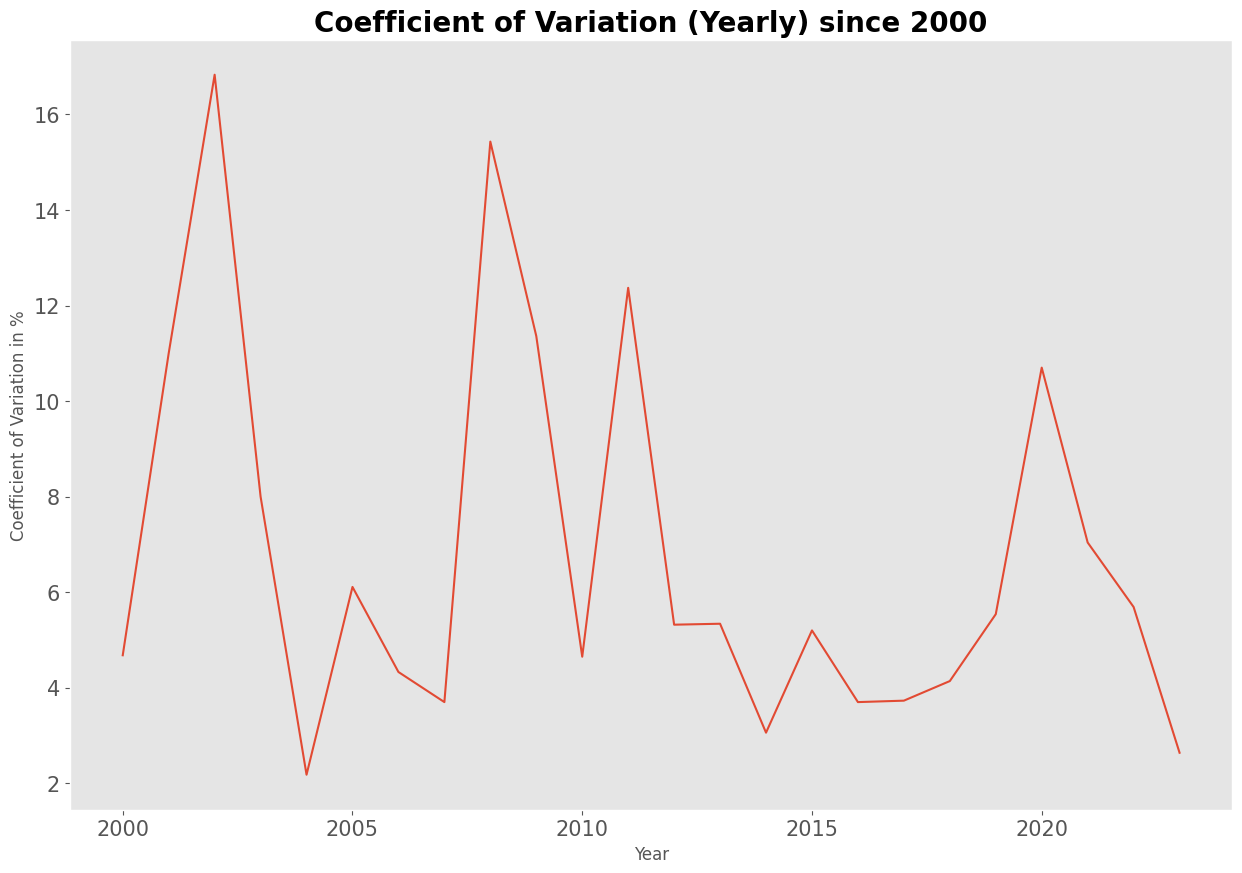

In [13]:
y1 = data[['Date','Close']].copy()
y1.set_index('Date', inplace=True)
y1.index = pd.to_datetime(y1.index)
dataset_Coef = y1.groupby(y1.index.year).mean().rename(columns={'Close':'Mean'})
dataset_Coef = dataset_Coef.merge(y1.groupby(y1.index.year).std().rename(columns={'Close':'Std'}),left_index=True,right_index=True)
dataset_Coef['CoV_pct'] = ((dataset_Coef['Std']/dataset_Coef['Mean'])*100).round(2)
fig, ax = plt.subplots(figsize=(15,10))
dataset_Coef['CoV_pct'].plot()
plt.title("Coefficient of Variation (Yearly) since 2000", fontsize = 20, fontdict=dict(weight='bold'))
plt.xlabel("Year")
plt.ylabel("Coefficient of Variation in %")
plt.grid()

## Further Exploratory Analysis of Closing Price with Technical Indicators

List of technical indicators and explanation:


* **SMA:** Simple Moving averages are probably the single most widely-used technical indicator. Moving averages are primarily focused on determining likely market direction, up or down.


* **EMA:** Exponential moving average is a better version of a simple moving average that doesnt have SMAs lag. Moving averages just average out the data for a given time so we know how the company's closing price are trending for a given amount of days. 

* **MACD:** The Moving Average Convergence Divergence (MACD) measures the relationship of EMAs. It is the difference between two exponentially levelled moving averages, usually 12 and 26-periods. The MACD measures momentum or trend strength by using the MACD line and zero line as reference points:

    * When the MACD line crosses ABOVE the zero line, this signals an UPTREND
    * When the MACD line crosses BELOW the zero line, this signals an DOWNTREND

* **Momentum:** Momentum is perhaps the simplest and easiest oscillator (financial analysis tool) to understand and use. It is the measurement of the speed or velocity of price changes, or the rate of change in price movement for a particular asset. The formula for momentum is:



In [28]:
import numpy as np
from ta.momentum import RSIIndicator, StochasticOscillator

def get_technical_indicators(dataset, shift_values=True):
    """
    Function to generate technical indicators with an option to shift values.

    Parameters:
    - dataset (pd.DataFrame): Input dataset containing 'Close', 'Open', 'High', and 'Low'.
    - shift_values (bool): If True, shifts all calculated indicators by 1 period.

    Returns:
    - pd.DataFrame: Dataset with technical indicators.
    """
    # Create 5, 10 and 20 days Moving Average
    dataset['SMA_5'] = dataset['Close'].rolling(window=5).mean()
    dataset['SMA_10'] = dataset['Close'].rolling(window=10).mean()
    dataset['SMA_20'] = dataset['Close'].rolling(window=20).mean()

    # Create 5, 10 and 20 days Weighted Moving Average
    dataset['WMA_5'] = dataset['Close'].rolling(window=5).apply(lambda x: np.dot(x, np.arange(1, 6))/15, raw=True)
    dataset['WMA_10'] = dataset['Close'].rolling(window=10).apply(lambda x: np.dot(x, np.arange(1, 11))/55, raw=True)
    dataset['WMA_20'] = dataset['Close'].rolling(window=20).apply(lambda x: np.dot(x, np.arange(1, 21))/210, raw=True)

    # Create MACD
    ema26 = dataset['Close'].ewm(span=26).mean()
    ema12 = dataset['Close'].ewm(span=12).mean()
    dataset['MACD'] = ema12 - ema26

    # RSI
    dataset['RSI'] = RSIIndicator(dataset['Close'].squeeze(), window=10).rsi()

    # Stochastic Oscillator (%K)
    stochastic_oscillator = StochasticOscillator(
        close=dataset['Close'],
        low=dataset['Low'],
        high=dataset['High'],
        window=14,
        smooth_window=3
    )
    dataset['Stochastic_K'] = stochastic_oscillator.stoch()  # %K
    dataset['Stochastic_D'] = dataset['Stochastic_K'].rolling(window=3).mean()  # %D (smoothed %K)

    # Williams %R
    dataset['Williams_R'] = (dataset['High'].rolling(window=14).max() - dataset['Close']) / \
                            (dataset['High'].rolling(window=14).max() - dataset['Low'].rolling(window=14).min())

    # High-Low Average and Close-Open
    dataset['Close_minus_Open'] = dataset['Close'] - dataset['Open']
    dataset['High_minus_Low'] = dataset['High'] - dataset['Low']

    # Commodity Channel Index (CCI)
    TP = (dataset['High'] + dataset['Low'] + dataset['Close']) / 3
    SMA = TP.rolling(window=10).mean()
    mad = TP.rolling(window=10).apply(lambda x: np.mean(np.abs(x - np.mean(x))), raw=True)
    dataset['CCI'] = (TP - SMA) / (0.015 * mad)

    # Momentum
    dataset['Momentum'] = dataset['Close'].diff(periods=10)

    # Apply shifting if shift_values is True
    if shift_values:
        indicator_columns = [
            'SMA_5', 'SMA_10', 'SMA_20',
            'WMA_5', 'WMA_10', 'WMA_20',
            'MACD', 'RSI', 'Stochastic_K', 'Stochastic_D',
            'Williams_R', 'Close_minus_Open', 'High_minus_Low',
            'CCI', 'Momentum'
        ]
        dataset[indicator_columns] = dataset[indicator_columns].shift(1)

    return dataset

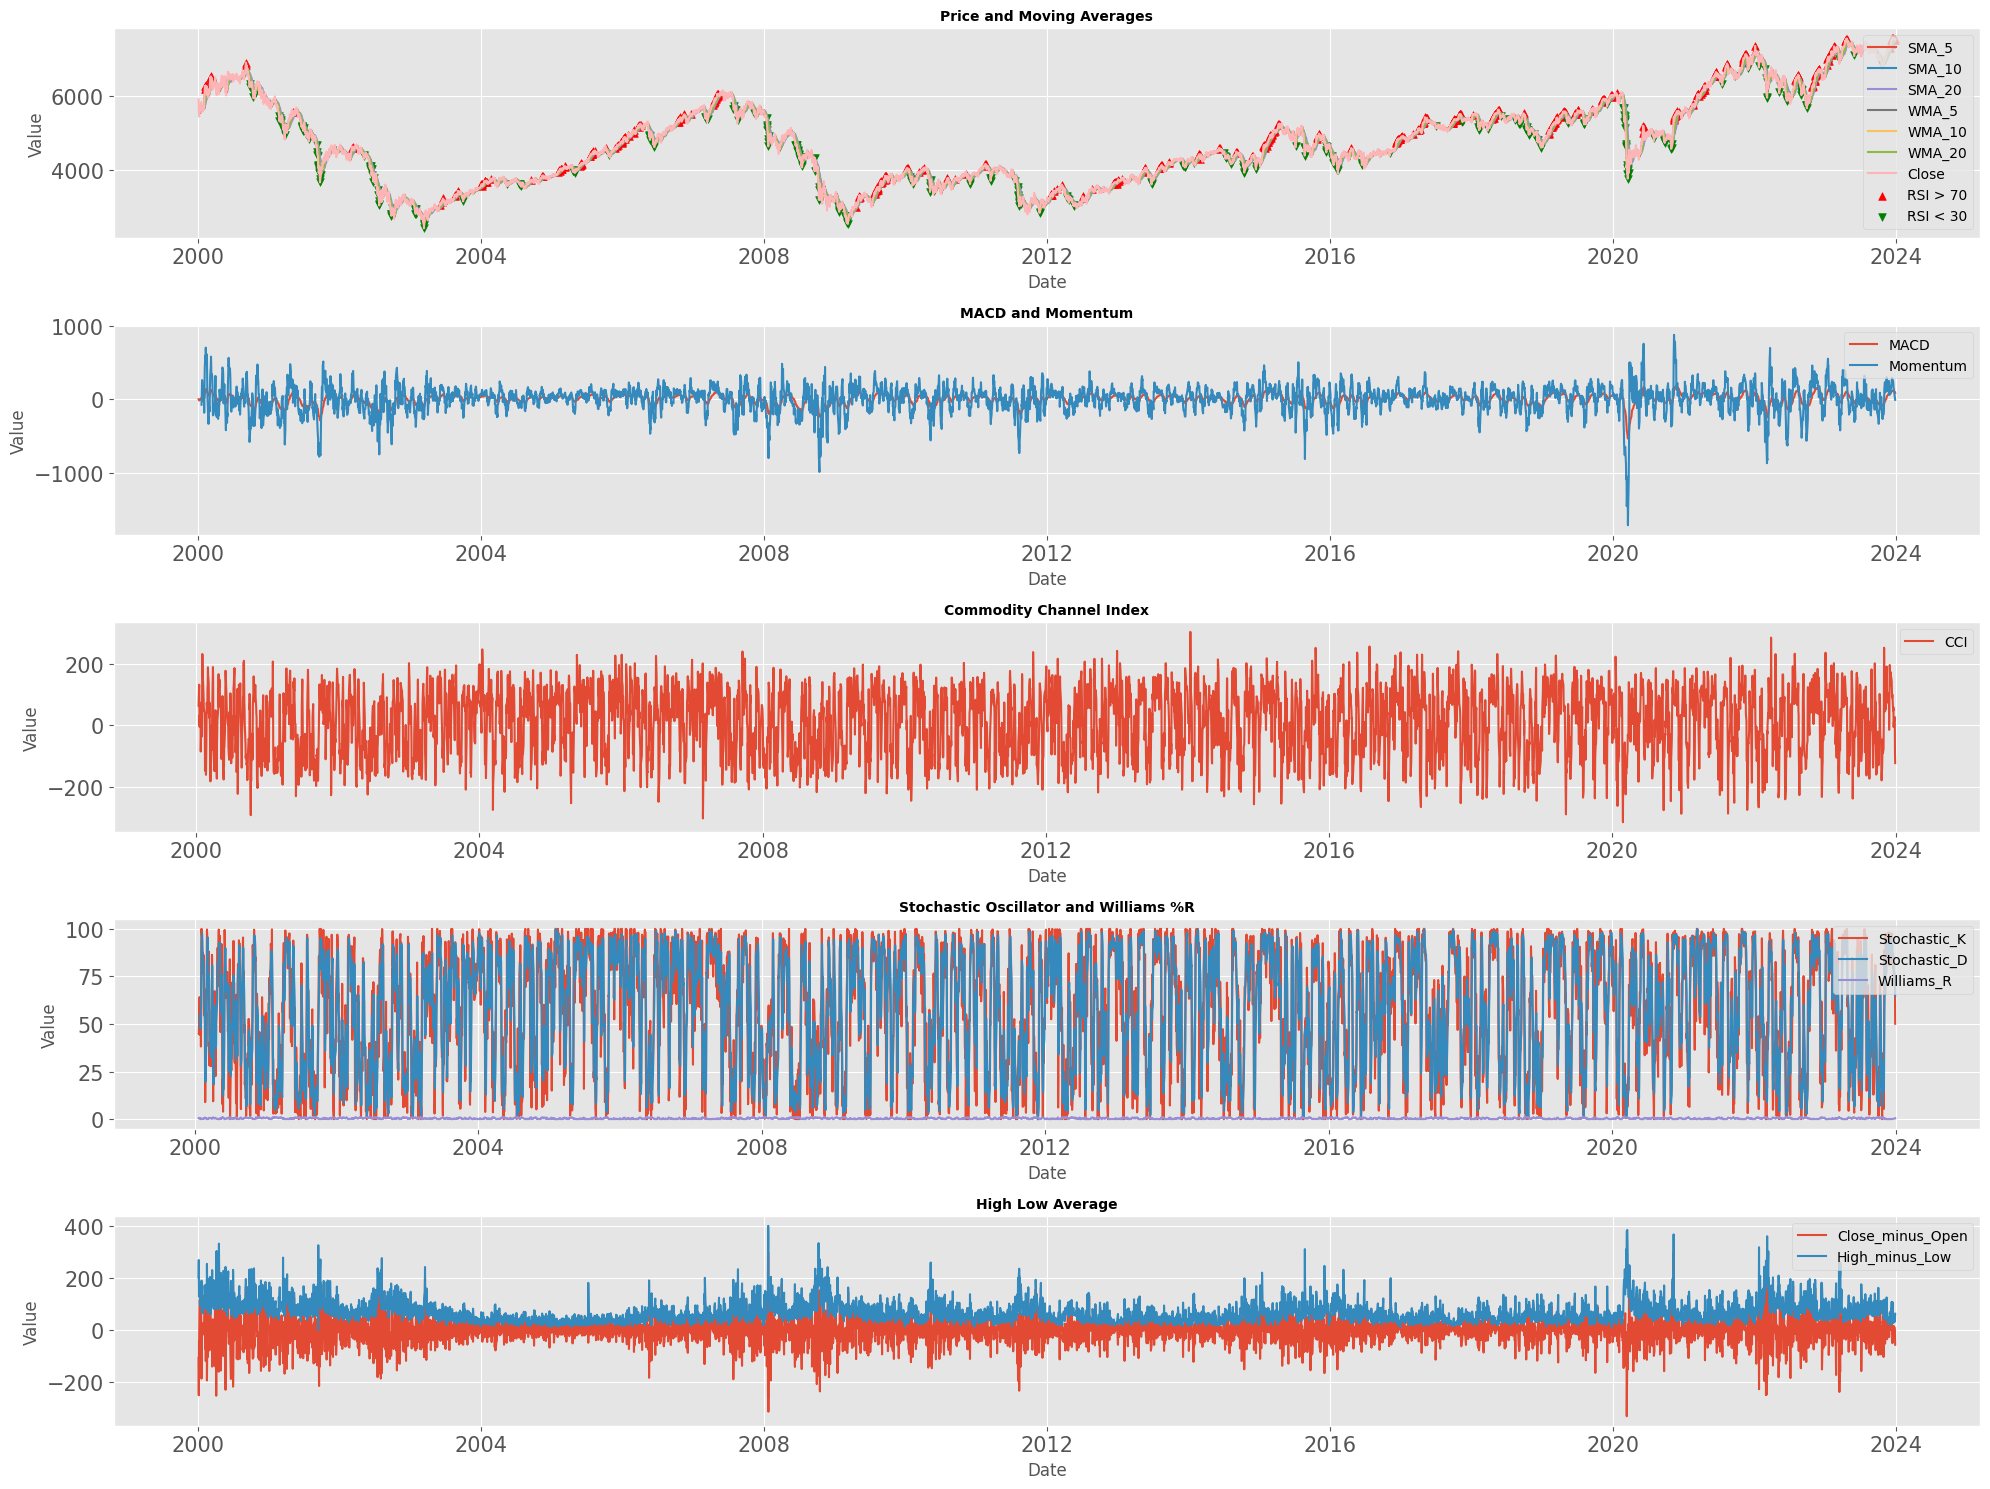

In [27]:
def plot_technical_indicators(dataset, selected_variables):
    fig, axs = plt.subplots(5, 1, figsize=(20, 15))

    # Map subplot categories to available indicators
    subplot_mapping = [
        ("Price and Moving Averages", ["SMA_5", "SMA_10", "SMA_20", "WMA_5", "WMA_10", "WMA_20", "Close", "RSI"]),
        ("MACD and Momentum", ["MACD", "Momentum"]),
        ("Commodity Channel Index", ["CCI"]),
        ("Stochastic Oscillator and Williams %R", ["Stochastic_K", "Stochastic_D", "Williams_R"]),
        ("High Low Average", ["Close_minus_Open", "High_minus_Low"])
    ]

    for ax, (title, available_indicators) in zip(axs, subplot_mapping):
        # Select only the indicators specified by the user for this category
        indicators_to_plot = [var for var in selected_variables.get(title, []) if var in available_indicators]

        # Plot only if there are selected indicators for the subplot
        if indicators_to_plot:
            ax.set_title(title, fontsize=10, loc='center', fontdict=dict(weight='bold'))
            
            for indicator in indicators_to_plot:
                if indicator == "RSI":  # Special handling for RSI markers
                    ax.scatter(dataset[dataset['RSI'] > 70]['Date'], dataset[dataset['RSI'] > 70]['Close'],
                               color='red', label='RSI > 70', marker='^', s=30)
                    ax.scatter(dataset[dataset['RSI'] < 30]['Date'], dataset[dataset['RSI'] < 30]['Close'],
                               color='green', label='RSI < 30', marker='v', s=30)
                else:
                    ax.plot(dataset['Date'], dataset[indicator], label=indicator)

            ax.legend(loc = 'upper right')
            ax.set_xlabel('Date')
            ax.set_ylabel('Value')

    # Adjust layout and display
    plt.tight_layout()
    plt.show()


# Example of user-defined selections for each plot
selected_variables = {
    "Price and Moving Averages":  ["SMA_5", "SMA_10", "SMA_20", "WMA_5", "WMA_10", "WMA_20", "Close", "RSI"],
    "MACD and Momentum": ["MACD", "Momentum"],
    "Commodity Channel Index": ["CCI"],
    "Stochastic Oscillator and Williams %R": ["Stochastic_K", "Stochastic_D", "Williams_R"],
    "High Low Average": ["Close_minus_Open", "High_minus_Low"]
}

# Call the function with the selected variables
plot_technical_indicators(get_technical_indicators(data), selected_variables)
